In [1]:
import pandas as pd
import sklearn 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.Sex.unique()

array(['male', 'female'], dtype=object)

In [4]:
df['Sex_binary'] = np.where(df['Sex'] == "female", 1, 0)
df.drop(columns='Sex', inplace=True)

In [5]:

# set Embarked_ternary to 1 for C, 2 for Q, 3 for S
df['Embarked_ternary'] = np.where(df["Embarked"] == "C", 1, 
         (np.where(df["Embarked"] == "Q", 2, 3)))


In [6]:
df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_binary,Embarked_ternary
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,3
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,3
5,6,0,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,NaN,Q,0,2
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,E46,S,0,3
7,8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,NaN,S,0,3
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,NaN,S,1,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,NaN,C,1,1


In [7]:
count_nan = len(df['Cabin']) - df['Cabin'].count()


In [8]:
count_nan

687

OK, so most of the Cabin values are NaN, so we can probably drop this column.

In [9]:
df.drop(columns='Cabin', inplace=True)

Not sure about name column, might be useful data in len(name)?

In [10]:
df

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_binary,Embarked_ternary
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,S,0,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,S,1,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,S,1,3
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,S,0,3
5,6,0,3,"Moran, Mr. James",NaN,0,0,330877,8.4583,Q,0,2
6,7,0,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,S,0,3
7,8,0,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,S,0,3
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,S,1,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,C,1,1


In [11]:
# Slightly more likely to survive if younger
df.groupby(['Survived']).Age.mean()


Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

In [12]:
df.groupby(['Survived']).Fare.mean()


Survived
0    22.117887
1    48.395408
Name: Fare, dtype: float64

In [13]:
# who embarked at Cherbourg?
print("number embarked at Cherbourg", len(df.loc[df['Embarked_ternary'] == 1]))

print("average survival status", df.loc[df['Embarked_ternary'] == 1].Survived.mean())


number embarked at Cherbourg 168
average survival status 0.5535714285714286


In [14]:
# who embarked at Queenstown?

print("number embarked at Queenstown", len(df.loc[df['Embarked_ternary'] == 2]))

print("average survival status", df.loc[df['Embarked_ternary'] == 2].Survived.mean())


number embarked at Queenstown 77
average survival status 0.38961038961038963


In [15]:
# who embarked at Southampton?
print("number embarked at Southampton", len(df.loc[df['Embarked_ternary'] == 3]))

print("average survival status", df.loc[df['Embarked_ternary'] == 3].Survived.mean())


number embarked at Southampton 646
average survival status 0.33900928792569657


OK, so there is some evidence that embarking at Cherbourg is correlated with survival. So let's turn embarkation_ternary into a binary condition: emarbarked_at_cherbourg

In [16]:
df['Embarked_at_cherbourg'] = np.where(df['Embarked_ternary'] == 1, 1, 0)

In [17]:
df.dtypes

PassengerId                int64
Survived                   int64
Pclass                     int64
Name                      object
Age                      float64
SibSp                      int64
Parch                      int64
Ticket                    object
Fare                     float64
Embarked                  object
Sex_binary                 int64
Embarked_ternary           int64
Embarked_at_cherbourg      int64
dtype: object

In [18]:
df.drop(columns="Embarked_ternary", inplace=True)

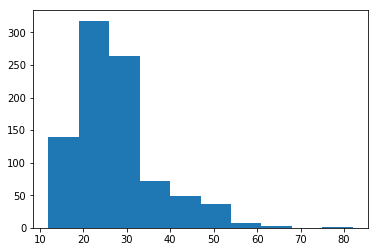

In [19]:
# how do the name lengths vary? And are they correlated with survival?

names_lens = [(name[1], len(name[1])) for name in df["Name"].iteritems()]
name_lens = [name_len[1] for name_len in names_lens]
plt.hist(name_lens)
plt.show()


In [20]:
# add an int value for name length
df['Name_len'] = [len(name[1]) for name in df["Name"].iteritems()]


In [21]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_binary,Embarked_at_cherbourg,Name_len
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.042939,-0.001205,-0.012986
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,0.168240,0.332350
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,-0.243292,-0.220001
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.036261,0.034612
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.059528,0.165019
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.011069,0.252282
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,0.269335,0.155832
Sex_binary,-0.042939,0.543351,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,0.082853,0.448759
Embarked_at_cherbourg,-0.001205,0.168240,-0.243292,0.036261,-0.059528,-0.011069,0.269335,0.082853,1.000000,0.027481
Name_len,-0.012986,0.332350,-0.220001,0.034612,0.165019,0.252282,0.155832,0.448759,0.027481,1.000000


In [22]:
# woah, having a long name is almost as highly correlated with survival as passanger class!

In [23]:
# todo: engineer ticket class
# for now, we'll just drop it

df.drop(columns=['PassengerId', 'Embarked', 'Name', 'Ticket'], inplace=True)




In [24]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_binary,Embarked_at_cherbourg,Name_len
0,0,3,22.0,1,0,7.2500,0,0,23
1,1,1,38.0,1,0,71.2833,1,1,51
2,1,3,26.0,0,0,7.9250,1,0,22
3,1,1,35.0,1,0,53.1000,1,0,44
4,0,3,35.0,0,0,8.0500,0,0,24


In [25]:
df.dtypes

Survived                   int64
Pclass                     int64
Age                      float64
SibSp                      int64
Parch                      int64
Fare                     float64
Sex_binary                 int64
Embarked_at_cherbourg      int64
Name_len                   int64
dtype: object

In [26]:
df.isnull().any()


Survived                 False
Pclass                   False
Age                       True
SibSp                    False
Parch                    False
Fare                     False
Sex_binary               False
Embarked_at_cherbourg    False
Name_len                 False
dtype: bool

We have some null ages. Let's see how many.

In [27]:
len(df.loc[df.Age.isnull()])

177

And how are they distributed?

In [28]:
# naively drop nulls for now
df.dropna(inplace=True)

In [29]:
"""X = df.drop('Survived', axis=1)  
y = df['Survived']  

X_train = X
y_train = y"""

"X = df.drop('Survived', axis=1)  \ny = df['Survived']  \n\nX_train = X\ny_train = y"

In [30]:
# make a function with preceding data-wrangling steps, so that we can perform the same operations on the test set
def wrangle(df):
    """
    takes a df with same format as training set.
    returns df in same format as modified training set
    """
    df['Sex_binary'] = np.where(df['Sex'] == "female", 1, 0)
    df.drop(columns='Sex', inplace=True)
    df['Embarked_ternary'] = np.where(df["Embarked"] == "C", 1, 
         (np.where(df["Embarked"] == "Q", 2, 3)))
    df.drop(columns='Cabin', inplace=True)
    df['Embarked_at_cherbourg'] = np.where(df['Embarked_ternary'] == 1, 1, 0)
    df.drop(columns="Embarked_ternary", inplace=True)
    names_lens = [(name[1], len(name[1])) for name in df["Name"].iteritems()]
    name_lens = [name_len[1] for name_len in names_lens]
    df['Name_len'] = [len(name[1]) for name in df["Name"].iteritems()]    
    df.drop(columns=['PassengerId', 'Embarked', 'Name', 'Ticket'], inplace=True)
    return df

In [31]:
# load and transform test data
df_test = pd.read_csv("test.csv")
df_test = wrangle(df_test)

In [32]:
import keras
from keras import models 
from keras import layers

/Users/kate/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [33]:
(train_passengers, train_labels) = (df.drop('Survived', axis=1), df['Survived'])

test_passengers = df_test

In [34]:
train_passengers.shape

(714, 8)

In [35]:
network = models.Sequential()
network.add(layers.Dense(714, activation='relu', input_shape=(8,)))
network.add(layers.Dense(2, activation='softmax'))

In [36]:
network.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
network.fit(train_passengers, train_labels, epochs=100, batch_size=8)


Epoch 1/100
714/714 [==============================] - 0s 238us/step - loss: 1.0725 - acc: 0.6597
Epoch 2/100
714/714 [==============================] - 0s 77us/step - loss: 0.7222 - acc: 0.7199
Epoch 3/100
714/714 [==============================] - 0s 79us/step - loss: 0.7344 - acc: 0.7297
Epoch 4/100
714/714 [==============================] - 0s 75us/step - loss: 0.7031 - acc: 0.7367
Epoch 5/100
714/714 [==============================] - 0s 77us/step - loss: 0.6757 - acc: 0.7339
Epoch 6/100
714/714 [==============================] - 0s 80us/step - loss: 0.7493 - acc: 0.7409
Epoch 7/100
714/714 [==============================] - 0s 77us/step - loss: 0.6395 - acc: 0.7619
Epoch 8/100
714/714 [==============================] - 0s 79us/step - loss: 0.6402 - acc: 0.7549
Epoch 9/100
714/714 [==============================] - 0s 77us/step - loss: 0.6350 - acc: 0.7745
Epoch 10/100
714/714 [==============================] - 0s 79us/step - loss: 0.5678 - acc: 0.7871
Epoch 11/100
714/714 [======

714/714 [==============================] - 0s 77us/step - loss: 0.4077 - acc: 0.8487
Epoch 85/100
714/714 [==============================] - 0s 84us/step - loss: 0.4001 - acc: 0.8291
Epoch 86/100
714/714 [==============================] - 0s 77us/step - loss: 0.4115 - acc: 0.8389
Epoch 87/100
714/714 [==============================] - 0s 85us/step - loss: 0.4180 - acc: 0.8347
Epoch 88/100
714/714 [==============================] - 0s 82us/step - loss: 0.4238 - acc: 0.8347
Epoch 89/100
714/714 [==============================] - 0s 81us/step - loss: 0.4062 - acc: 0.8445
Epoch 90/100
714/714 [==============================] - 0s 90us/step - loss: 0.4064 - acc: 0.8543
Epoch 91/100
714/714 [==============================] - 0s 81us/step - loss: 0.3992 - acc: 0.8473
Epoch 92/100
714/714 [==============================] - 0s 80us/step - loss: 0.4252 - acc: 0.8319
Epoch 93/100
714/714 [==============================] - 0s 80us/step - loss: 0.4092 - acc: 0.8319
Epoch 94/100
714/714 [===========

In [39]:
results = network.predict(test_passengers)

In [40]:
results.shape

(418, 2)

In [41]:
survived = []
for result in results:
    survived.append(result[1])
    

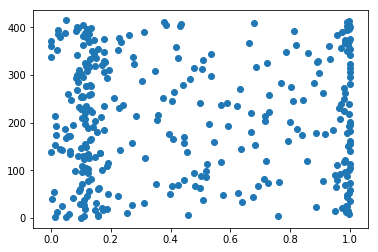

In [42]:
plt.scatter(survived, range(len(survived)))
plt.show()


### TODO
get validation set
get sucess of model on train and validation set with plot, to make sure not overfitting

make a load of synthetic features, like 'is female and lower class'

rescale data

use hyperparam grid search

regularise model

logisitc regression? SVM

cross_validate